<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2022-07-28 18:38:37--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2022-07-28 18:38:37--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2022-07-28 18:38:37 (140 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2022-07-28 18:38:37--
Total wall clock time: 0.1s
Downloaded: 1 files, 23K in 0s (140 MB/s)


In [5]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data.to(device)).cpu()
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos el mismo dataset de "Climate change" utilizado en la práctica de clase 2 y 3, a lo que sumo los links encontrados en la introducción de dicho artículo para ampliar el corpus.

In [52]:
html_pages = ['https://en.wikipedia.org/wiki/Climate_change',
              'https://en.wikipedia.org/wiki/Greenhouse_gas_emissions',
              'https://en.wikipedia.org/wiki/Polar_amplification',
              'https://en.wikipedia.org/wiki/Ocean_acidification',
              'https://en.wikipedia.org/wiki/Economic_impacts_of_climate_change',
              'https://en.wikipedia.org/wiki/Environmental_migrant',
              'https://en.wikipedia.org/wiki/Extreme_weather',
              'https://en.wikipedia.org/wiki/Heat_wave',
              'https://en.wikipedia.org/wiki/Wildfire',
              'https://en.wikipedia.org/wiki/Extinction_risk_from_climate_change',
              'https://en.wikipedia.org/wiki/Fossil_fuel_phase-out',
              'https://en.wikipedia.org/wiki/Carbon_farming',
              'https://en.wikipedia.org/wiki/Climate_change_adaptation']

In [53]:
citas_por_articulo = [357, 140, 46, 201, 64, 28, 64, 67, 283, 48, 177, 55, 134]

In [54]:
article_text = ''
for i, page in enumerate(html_pages):
  raw_html = urllib.request.urlopen(page)
  raw_html = raw_html.read()

  article_html = bs.BeautifulSoup(raw_html, 'lxml')
  article_paragraphs = article_html.find_all('p')

  for para in article_paragraphs:
      article_text += para.text

  article_text = article_text.lower()

  for j,citas in enumerate(citas_por_articulo):
    for k in range(citas):
      article_text = article_text.replace('['+str(k+1)+']', '')

In [6]:
raw_html = urllib.request.urlopen('https://en.wikipedia.org/wiki/Climate_change')
raw_html = raw_html.read()

article_html = bs.BeautifulSoup(raw_html, 'lxml')

article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

In [7]:
citas = 357 #Numero de citas maximas
for i in range(citas):
  article_text = article_text.replace('['+str(i+1)+']', '')

In [55]:
article_text = article_text.replace('\n', '') #Remove end of line '\n'
article_text = re.split(r"\.\s*", article_text) #Split using period '.'

In [56]:
df = pd.DataFrame(article_text)
df.head()

,0
0,contemporary climate change includes both glob...
1,there have been previous periods of climate ch...
2,"instead, they are caused by the emission of gr..."
3,burning fossil fuels for energy production cre...
4,"certain agricultural practices, industrial pro..."


In [57]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2977


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [58]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [59]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

"contemporary climate change includes both global warming and its impacts on earth's weather patterns"

In [60]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['contemporary',
 'climate',
 'change',
 'includes',
 'both',
 'global',
 'warming',
 'and',
 'its',
 'impacts',
 'on',
 "earth's",
 'weather',
 'patterns']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [61]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [62]:
# Demos un vistazo
sentence_tokens[:2]

[['contemporary',
  'climate',
  'change',
  'includes',
  'both',
  'global',
  'warming',
  'and',
  'its',
  'impacts',
  'on',
  "earth's",
  'weather',
  'patterns'],
 ['there',
  'have',
  'been',
  'previous',
  'periods',
  'of',
  'climate',
  'change',
  'but',
  'the',
  'current',
  'changes',
  'are',
  'distinctly',
  'more',
  'rapid',
  'and',
  'not',
  'due',
  'to',
  'natural',
  'causes']]

In [63]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [64]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences

[['contemporary', 'climate', 'change', 'includes'],
 ['climate', 'change', 'includes', 'both'],
 ['change', 'includes', 'both', 'global'],
 ['includes', 'both', 'global', 'warming'],
 ['both', 'global', 'warming', 'and'],
 ['global', 'warming', 'and', 'its'],
 ['warming', 'and', 'its', 'impacts'],
 ['and', 'its', 'impacts', 'on'],
 ['its', 'impacts', 'on', "earth's"],
 ['impacts', 'on', "earth's", 'weather']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [65]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [66]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[12, 10, 8, 1],
 [10, 8, 1, 2],
 [8, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 7],
 [5, 6, 7, 9],
 [6, 7, 9, 11],
 [7, 9, 11, 13]]

In [67]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

10


In [68]:
# Cantidad de palabras distintas
print(len(tok.word_counts))

13


In [69]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'includes': 1, 'both': 2, 'global': 3, 'warming': 4, 'and': 5, 'its': 6, 'impacts': 7, 'change': 8, 'on': 9, 'climate': 10, "earth's": 11, 'contemporary': 12, 'weather': 13}


In [70]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'change': 3, 'contemporary': 1, 'includes': 4, 'climate': 2, 'both': 4, 'global': 4, 'warming': 4, 'and': 4, 'its': 4, 'impacts': 4, 'on': 3, "earth's": 2, 'weather': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [71]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     contemporary climate change includes both glob...
1     there have been previous periods of climate ch...
2     instead, they are caused by the emission of gr...
3     burning fossil fuels for energy production cre...
4     certain agricultural practices, industrial pro...
5     greenhouse gases are transparent to sunlight, ...
6     when the earth emits that heat as infrared rad...
7     due to climate change, deserts are expanding, ...
8     increased warming in the arctic has contribute...
9     higher temperatures are also causing more inte...
10    rapid environmental change in mountains, coral...
11    climate change threatens people with food and ...
12         human migration and conflict can be a result
13    the world health organization (who) calls clim...
14    even if efforts to minimise future warming are...
15    these include sea level rise, and warmer, more...
Name: 0, dtype: object

In [72]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'contemporary climate change includes both global warming and its impacts on earth\'s weather patterns there have been previous periods of climate change, but the current changes are distinctly more rapid and not due to natural causes instead, they are caused by the emission of greenhouse gases, mostly carbon dioxide (co2) and methane burning fossil fuels for energy production creates most of these emissions certain agricultural practices, industrial processes, and forest loss are additional sources greenhouse gases are transparent to sunlight, allowing it through to heat the earth\'s surface when the earth emits that heat as infrared radiation the gases absorb it, trapping the heat near the earth\'s surface and causing global warming due to climate change, deserts are expanding, while heat waves and wildfires are becoming more common increased warming in the arctic has contributed to melting permafrost, glacial retreat and sea ice loss higher temperatures are also causing more intense

In [73]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['contemporary',
 'climate',
 'change',
 'includes',
 'both',
 'global',
 'warming',
 'and',
 'its',
 'impacts',
 'on',
 "earth's",
 'weather',
 'patterns',
 'there',
 'have',
 'been',
 'previous',
 'periods',
 'of']

In [74]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 57447


In [75]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [76]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['contemporary', 'climate', 'change', 'includes'],
 ['climate', 'change', 'includes', 'both'],
 ['change', 'includes', 'both', 'global'],
 ['includes', 'both', 'global', 'warming'],
 ['both', 'global', 'warming', 'and'],
 ['global', 'warming', 'and', 'its'],
 ['warming', 'and', 'its', 'impacts'],
 ['and', 'its', 'impacts', 'on'],
 ['its', 'impacts', 'on', "earth's"],
 ['impacts', 'on', "earth's", 'weather'],
 ['on', "earth's", 'weather', 'patterns'],
 ["earth's", 'weather', 'patterns', 'there'],
 ['weather', 'patterns', 'there', 'have'],
 ['patterns', 'there', 'have', 'been'],
 ['there', 'have', 'been', 'previous'],
 ['have', 'been', 'previous', 'periods'],
 ['been', 'previous', 'periods', 'of'],
 ['previous', 'periods', 'of', 'climate'],
 ['periods', 'of', 'climate', 'change'],
 ['of', 'climate', 'change', 'but']]

In [77]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[2045, 13, 16, 747],
 [13, 16, 747, 145],
 [16, 747, 145, 26],
 [747, 145, 26, 38],
 [145, 26, 38, 3],
 [26, 38, 3, 119],
 [38, 3, 119, 56],
 [3, 119, 56, 17],
 [119, 56, 17, 250],
 [56, 17, 250, 59],
 [17, 250, 59, 361],
 [250, 59, 361, 79],
 [59, 361, 79, 22],
 [361, 79, 22, 54],
 [79, 22, 54, 984],
 [22, 54, 984, 311],
 [54, 984, 311, 2],
 [984, 311, 2, 13],
 [311, 2, 13, 16],
 [2, 13, 16, 104]]

In [78]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 57443


### 3 - Input y target

In [79]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [80]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [81]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [82]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(57443, 3)
(57443,)


In [83]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'to',
 5: 'in',
 6: 'a',
 7: 'is',
 8: 'that',
 9: 'as',
 10: 'are',
 11: 'for',
 12: 'by',
 13: 'climate',
 14: 'from',
 15: 'be',
 16: 'change',
 17: 'on',
 18: 'carbon',
 19: 'can',
 20: 'or',
 21: 'with',
 22: 'have',
 23: 'emissions',
 24: 'more',
 25: 'heat',
 26: 'global',
 27: 'at',
 28: 'energy',
 29: 'has',
 30: 'this',
 31: 'it',
 32: 'also',
 33: 'may',
 34: 'an',
 35: 'fire',
 36: 'ocean',
 37: 'such',
 38: 'warming',
 39: 'than',
 40: 'which',
 41: 'will',
 42: 'increase',
 43: 'other',
 44: 'co2',
 45: 'water',
 46: 'not',
 47: 'these',
 48: 'over',
 49: 'countries',
 50: 'wildfires',
 51: 'greenhouse',
 52: 'some',
 53: 'temperature',
 54: 'been',
 55: 'their',
 56: 'impacts',
 57: 'increased',
 58: 'human',
 59: 'weather',
 60: 'fossil',
 61: 'gas',
 62: 'they',
 63: 'effects',
 64: 'was',
 65: 'into',
 66: 'changes',
 67: 'use',
 68: 'due',
 69: 'most',
 70: 'adaptation',
 71: 'air',
 72: 'risk',
 73: 'land',
 74: 'when',
 75: 'wild

In [84]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6793

In [85]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [86]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [87]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 6793


In [88]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 45955
Tamaño del conjunto de validacion: 11488


### 4 - Entrenar el modelo

In [131]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        embedding_dim = 5 # --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=64) # Fully connected layer
        self.fc2 = nn.Linear(in_features=64, out_features=64) # Fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # Fully connected layer
        
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.tanh(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.tanh(self.fc2(out))
        out = self.softmax(self.fc3(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model1.cuda()

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
#summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device(device))

# otra posibilidad
summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 6793]                 --
├─Embedding: 1-1                         [1, 3, 5]                 33,970
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 64]                   4,160
├─Tanh: 1-4                              [1, 64]                   --
├─Linear: 1-5                            [1, 64]                   4,160
├─Tanh: 1-6                              [1, 64]                   --
├─Linear: 1-7                            [1, 6793]                 441,545
├─Softmax: 1-8                           [1, 6793]                 --
Total params: 535,291
Trainable params: 535,291
Non-trainable params: 0
Total mult-adds (M): 0.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 2.14
Estimated Total Size (MB): 2.20

In [132]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=20
                )

Epoch: 1/20 - Train loss 8.770 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 2/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 3/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 4/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 5/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 6/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 7/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 8/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 9/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 10/20 - Train loss 8.769 - Train accuracy 0.054 - Valid Loss 8.777 - Valid accuracy 0.047
Epoch: 11/20 - Train loss 8.769 - Train

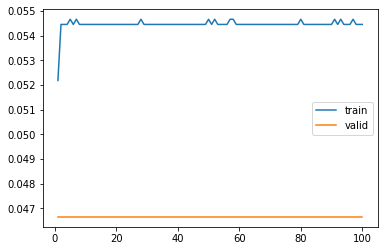

In [91]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

__Es importante__ destacar que en este ejemplo estamos entrenando nuestro propios Embeddings y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

### 5 - Predicción de próxima palabra

In [45]:
# pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [46]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 5.6 MB 33.8 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 212 kB 73.1 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 2.3 MB 58.4 MB/s 
     |████████████████████████████████| 141 kB 85.5 MB/s 
     |████████████████████████████████| 272 kB 53.4 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 80 kB 11.4 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 4.1 MB 58.5 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 856 kB 69.4 MB/s 


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://27260.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 256, in run_predict
    fn_index, raw_input, username, session_state
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 599, in process_api
    predictions, duration = await self.call_function(fn_index, processed_input)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 515, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 487, in <lam

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f2ac74c8c50>,
 'http://127.0.0.1:7860/',
 'https://27260.gradio.app')

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='climate change'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

'climate change  '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.